## H-Bonding with Temperature

Since we're unsure whether the Cp spike we're observing at 225 K is due to the solvent or the molecule, we need to investigate the average hydrogen bonds formed in each replica simulation. This will confirm if there is a significant change in the number of hydrogen bonds at low temperatures, indicating that the terphenyl molecule may be giving rise to the large heat capacity spike.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h_bonds
import matplotlib.pyplot as plt
import numpy as np
import pymbar
import heat_capacity
from multiprocessing import Pool

plt.style.use('ggplot')

In [3]:
remd_trajs = h_bonds.REMD_trajectories("/mnt/grays/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K", "npt", "whole.xtc","sim", "/mnt/grays/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K/sim0/berendsen.gro", np = 4)

ReplicaReplicaReplicaReplica    0396



npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtcnpt.whole.xtc

npt.part0002.whole.xtcnpt.part0002.whole.xtc

npt.part0003.whole.xtcnpt.part0003.whole.xtc
npt.part0004.whole.xtc

npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 10
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 1
Replica 7
Replica 4
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 11
Replica 2
Replica 8
Replica 5
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part000

In [4]:
h_bond_finder = h_bonds.HydrogenBondFinder(remd_trajs.trajs[0][0], remd_trajs.trajs[0][0].top)
h_bond_finder.get_donors()
h_bond_finder.get_acceptors()
n_h_bonds, h_bond_ids = h_bond_finder.get_hydrogen_bonds(remd_trajs.trajs[0])

100%|██████████| 3608/3608 [00:02<00:00, 1694.13it/s]


In [5]:
pool = Pool(4)

100%|██████████| 3608/3608 [00:02<00:00, 1607.63it/s]


In [6]:
n_h_bonds_remd, h_bonds_remd = zip(*pool.map(h_bond_finder.get_hydrogen_bonds, remd_trajs.trajs))

In [7]:
n_h_bonds_remd = np.array(n_h_bonds_remd)
h_bonds_remd = h_bonds_remd

In [8]:
temps = np.array(remd_trajs.temps)

Text(0.5, 0, 'Replica Temperature')

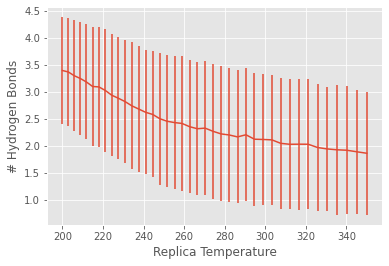

In [9]:
plt.errorbar(temps, np.mean(n_h_bonds_remd, axis = 1), yerr=np.std(n_h_bonds_remd, axis = 1))
plt.ylabel("# Hydrogen Bonds")
plt.xlabel("Replica Temperature")

Text(0.5, 0, 'Replica Temperature')

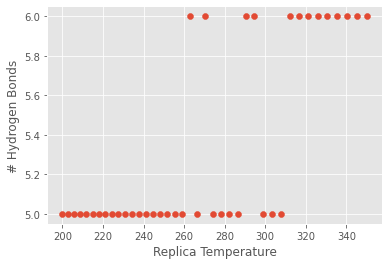

In [10]:
plt.scatter(temps, np.max(n_h_bonds_remd[:,1000:], axis = 1))
plt.ylabel("# Hydrogen Bonds")
plt.xlabel("Replica Temperature")

/home/lenny/anaconda3/envs/cg_pyrosetta/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/lenny/anaconda3/envs/cg_pyrosetta/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/lenny/anaconda3/envs/cg_pyrosetta/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may con

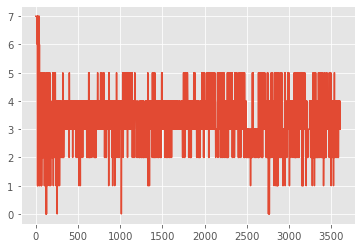

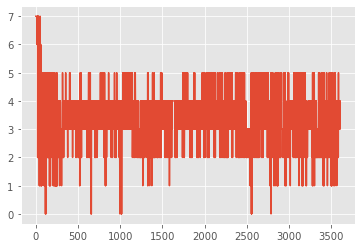

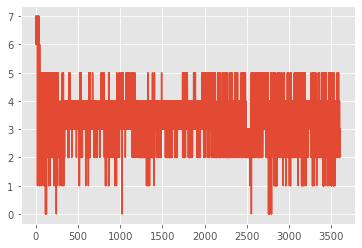

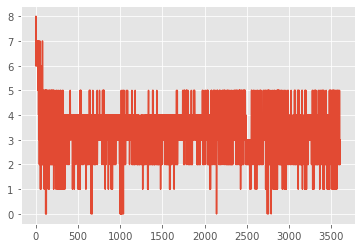

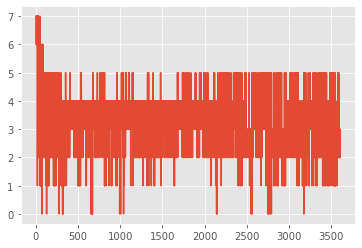

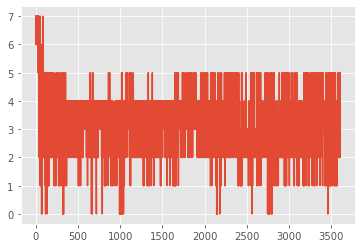

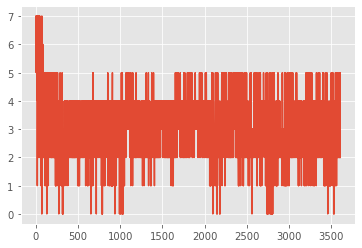

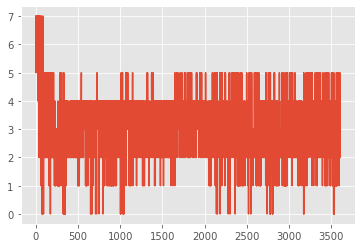

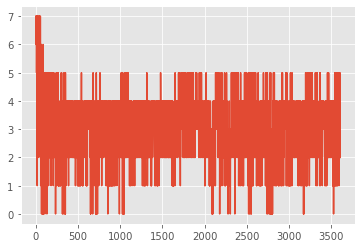

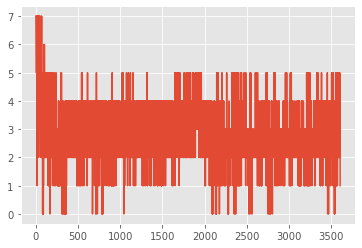

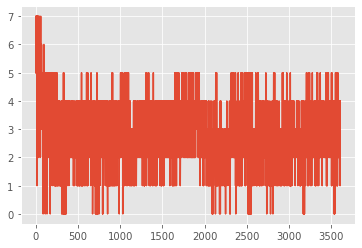

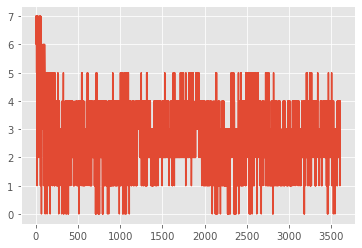

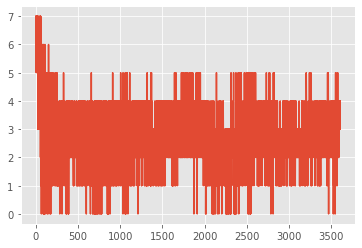

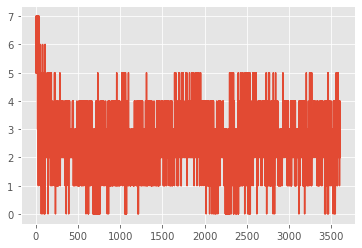

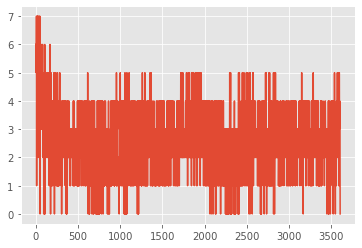

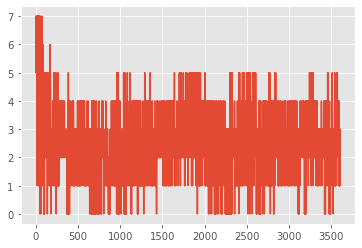

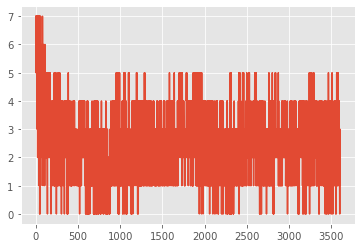

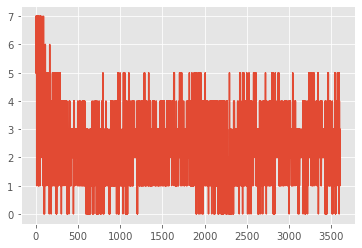

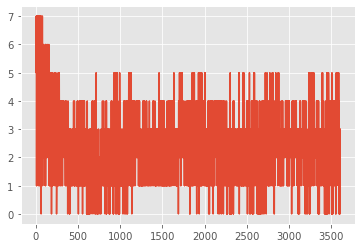

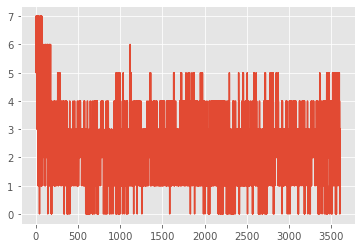

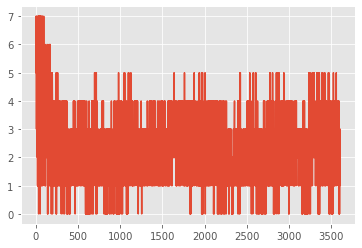

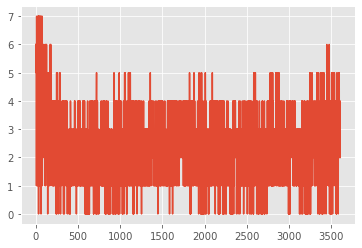

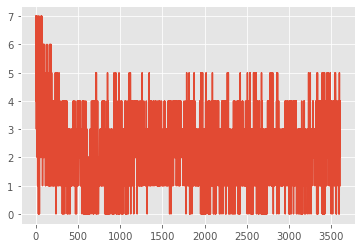

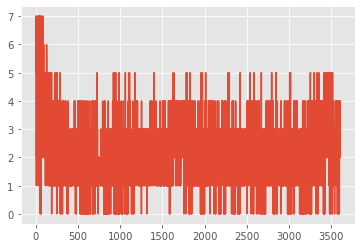

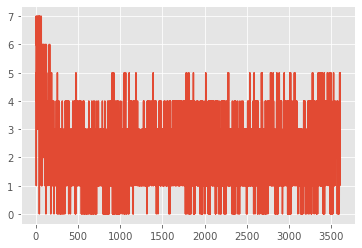

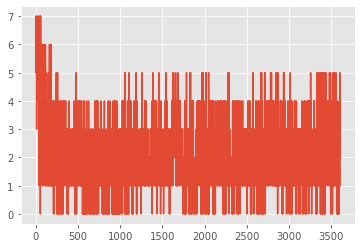

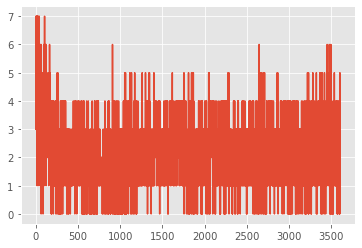

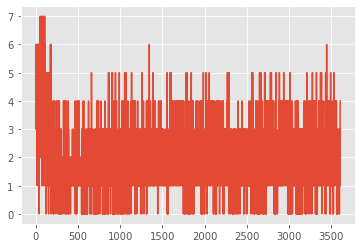

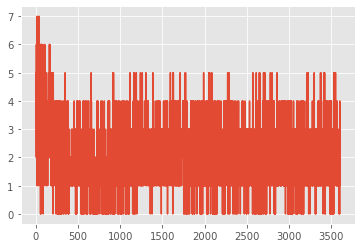

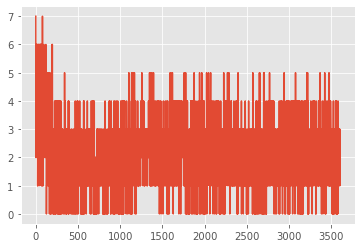

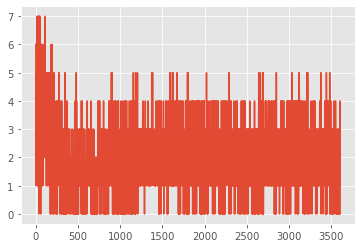

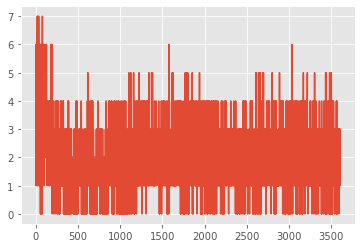

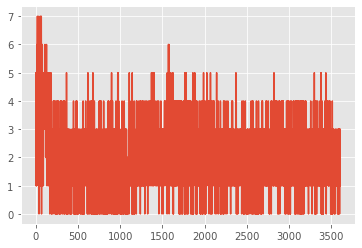

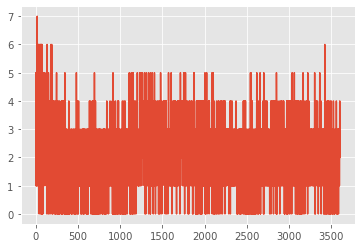

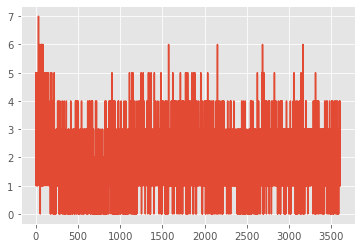

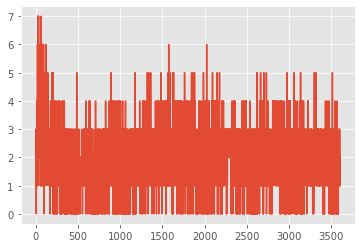

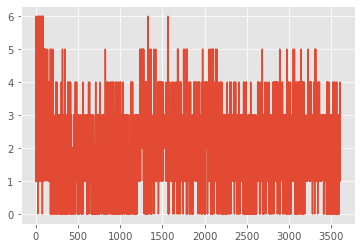

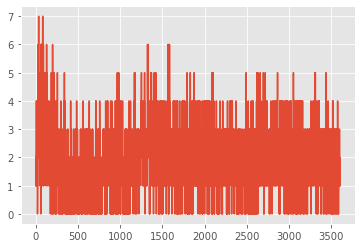

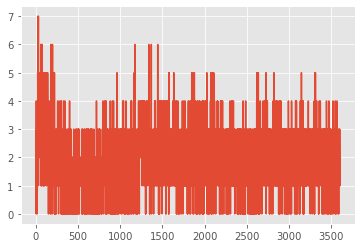

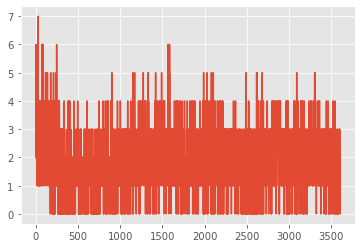

In [11]:
for i in range(n_h_bonds_remd.shape[0]):
    plt.figure()
    plt.plot(n_h_bonds_remd[i])

In [12]:
np.std(n_h_bonds_remd[:,1000:], axis=1)

array([0.91789193, 0.92265533, 0.94132233, 0.96042455, 0.95820729,
       1.01473458, 1.00793823, 1.01484433, 1.02175784, 0.99880539,
       1.03380804, 1.05621046, 1.04576486, 1.05322035, 1.07273408,
       1.11109807, 1.10751218, 1.10670264, 1.11400806, 1.10417139,
       1.07747985, 1.1326715 , 1.1133738 , 1.11791609, 1.13701937,
       1.11421393, 1.14487855, 1.14010294, 1.12865975, 1.12119653,
       1.11235019, 1.12175762, 1.12246652, 1.13382148, 1.14025304,
       1.10646701, 1.15842883, 1.11932275, 1.09450268, 1.08428959])

## H-bond analysis using ensemble averaging

Now that we've extracted the number of H-bonds per frame at each temperature we can use ensemble reweighting to get a continuous function of the number of hydrogen bonds over the range of replica temperatures.

In [13]:
# Extract Potential Energies from each simulation
sim_dir_name = "sim"
path = "/mnt/grays/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K/"
n_replicas = 40

energies, temps = heat_capacity.get_energies(sim_dir_name, path, n_replicas)

npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.edr
npt.edr
npt.part0002.edr
npt.part0003.edr
npt.part0004.e

In [14]:
u_kln, n_samples, t_list, betas = heat_capacity.construct_u_kln_matrix(temps, energies, add_temps = np.linspace(200, 350, 200))

In [15]:
h_bonds_kln = np.zeros([240, 240, 3608])
for k in range(n_h_bonds_remd.shape[0]):
    for l in range(h_bonds_kln.shape[0]):
        h_bonds_kln[k,l,:] = n_h_bonds_remd[k]

In [16]:
for i in range(h_bonds_kln.shape[0]):
    # print(h_bonds_kln)
    print(np.average(h_bonds_kln[i, :]))

3.393847006651885
3.367239467849224
3.297949002217295
3.2466740576496673
3.1818181818181817
3.0981152993348116
3.0903547671840355
3.024667405764967
2.936252771618625
2.880543237250554
2.819013303769401
2.740576496674058
2.6812638580931263
2.6202882483370287
2.5809312638580932
2.5011086474501107
2.454822616407982
2.4301552106430155
2.414356984478936
2.354212860310421
2.316518847006652
2.3273281596452327
2.268569844789357
2.220620842572062
2.2006651884700665
2.1651884700665187
2.2045454545454546
2.1225055432372506
2.117516629711752
2.1105875831485585
2.046008869179601
2.0285476718403546
2.030210643015521
2.029379157427938
1.9684035476718404
1.9429046563192904
1.9265521064301552
1.9185144124168514
1.8902439024390243
1.8625277161862528
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

In [17]:
n_samples[:40] = h_bonds_kln.shape[-1]

In [18]:
mbar_h_bonds = pymbar.MBAR(u_kln[:,:,:3608], n_samples, verbose = True, relative_tolerance = 1e-10, initial_f_k= None, maximum_iterations=1000)

K (total states) = 240, total samples = 144320

They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.


They are therefore likely to to be the same thermodynamic state.  This can occasionally cause
numerical problems with computing the covariance of their energy difference, which must be
identically zero in any case. Consider combining them into a single state.

N_k = 
[3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608
 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608
 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608 3608    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  

In [19]:
# MBAR estimates of mean (and error in mean)
results = mbar_h_bonds.computeExpectations(h_bonds_kln, state_dependent=True, return_dict=True)

h_bonds_mu = results["mu"]
h_bonds_mu_err = results["sigma"]

In [20]:
# MBAR estimates of the 2nd moment (and error in 2nd moment)
results = mbar_h_bonds.computeExpectations(np.power(h_bonds_kln, 2), state_dependent=True, return_dict=True)

h_bonds_mu2 = results["mu"]
h_bonds_mu2_err = results["sigma"]

In [21]:
h_bonds_sigma = np.sqrt(h_bonds_mu2 - np.power(h_bonds_mu,2))
h_bonds_sigma.shape

(240,)

Text(0.5, 0, 'Temperature (K)')

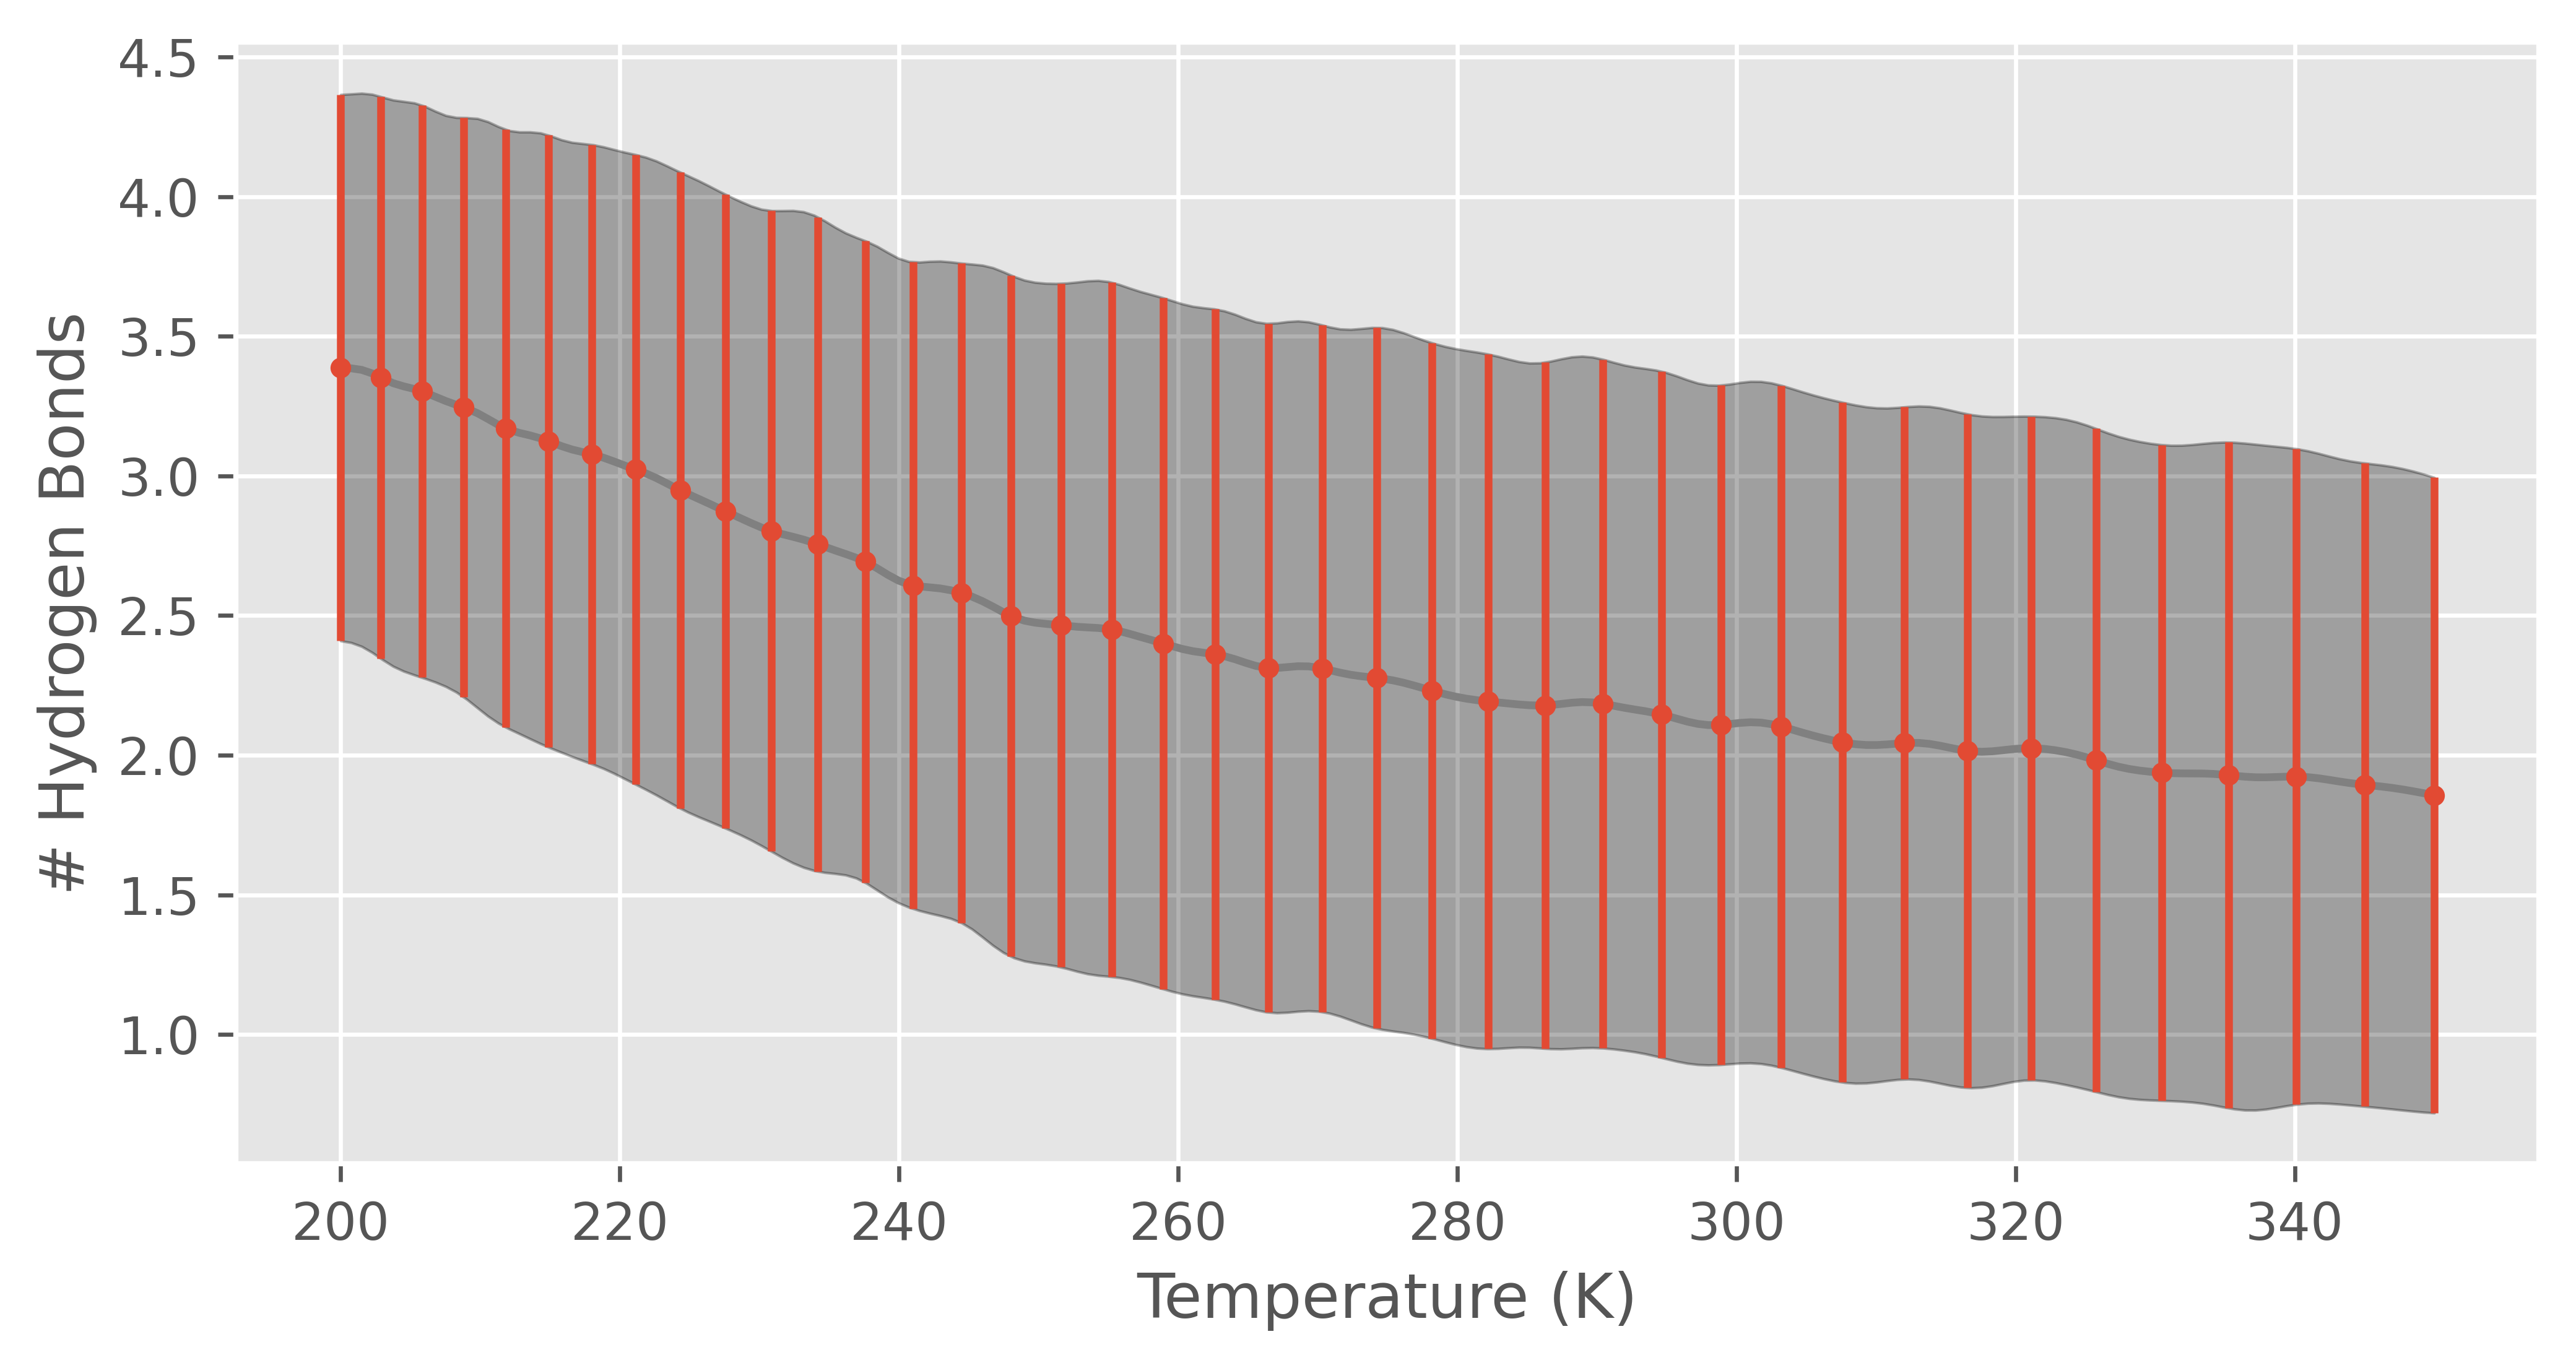

In [25]:
n_replicas = 40
plt.figure(figsize=[8,4], dpi=600)
# plt.scatter(t_list[:n_replicas], h_bonds_mu[:n_replicas])
plt.plot(t_list[n_replicas:], h_bonds_mu[n_replicas:], c="gray")
plt.errorbar(t_list[:n_replicas], h_bonds_mu[:n_replicas], yerr=h_bonds_sigma[:n_replicas], fmt=".")
plt.fill_between(t_list[n_replicas:], h_bonds_mu[n_replicas:]-h_bonds_sigma[n_replicas:],  h_bonds_mu[n_replicas:]+h_bonds_sigma[n_replicas:], color="black", alpha = 0.3)


plt.ylabel("# Hydrogen Bonds")
plt.xlabel("Temperature (K)")

Text(0.5, 0, 'Temperature (K)')

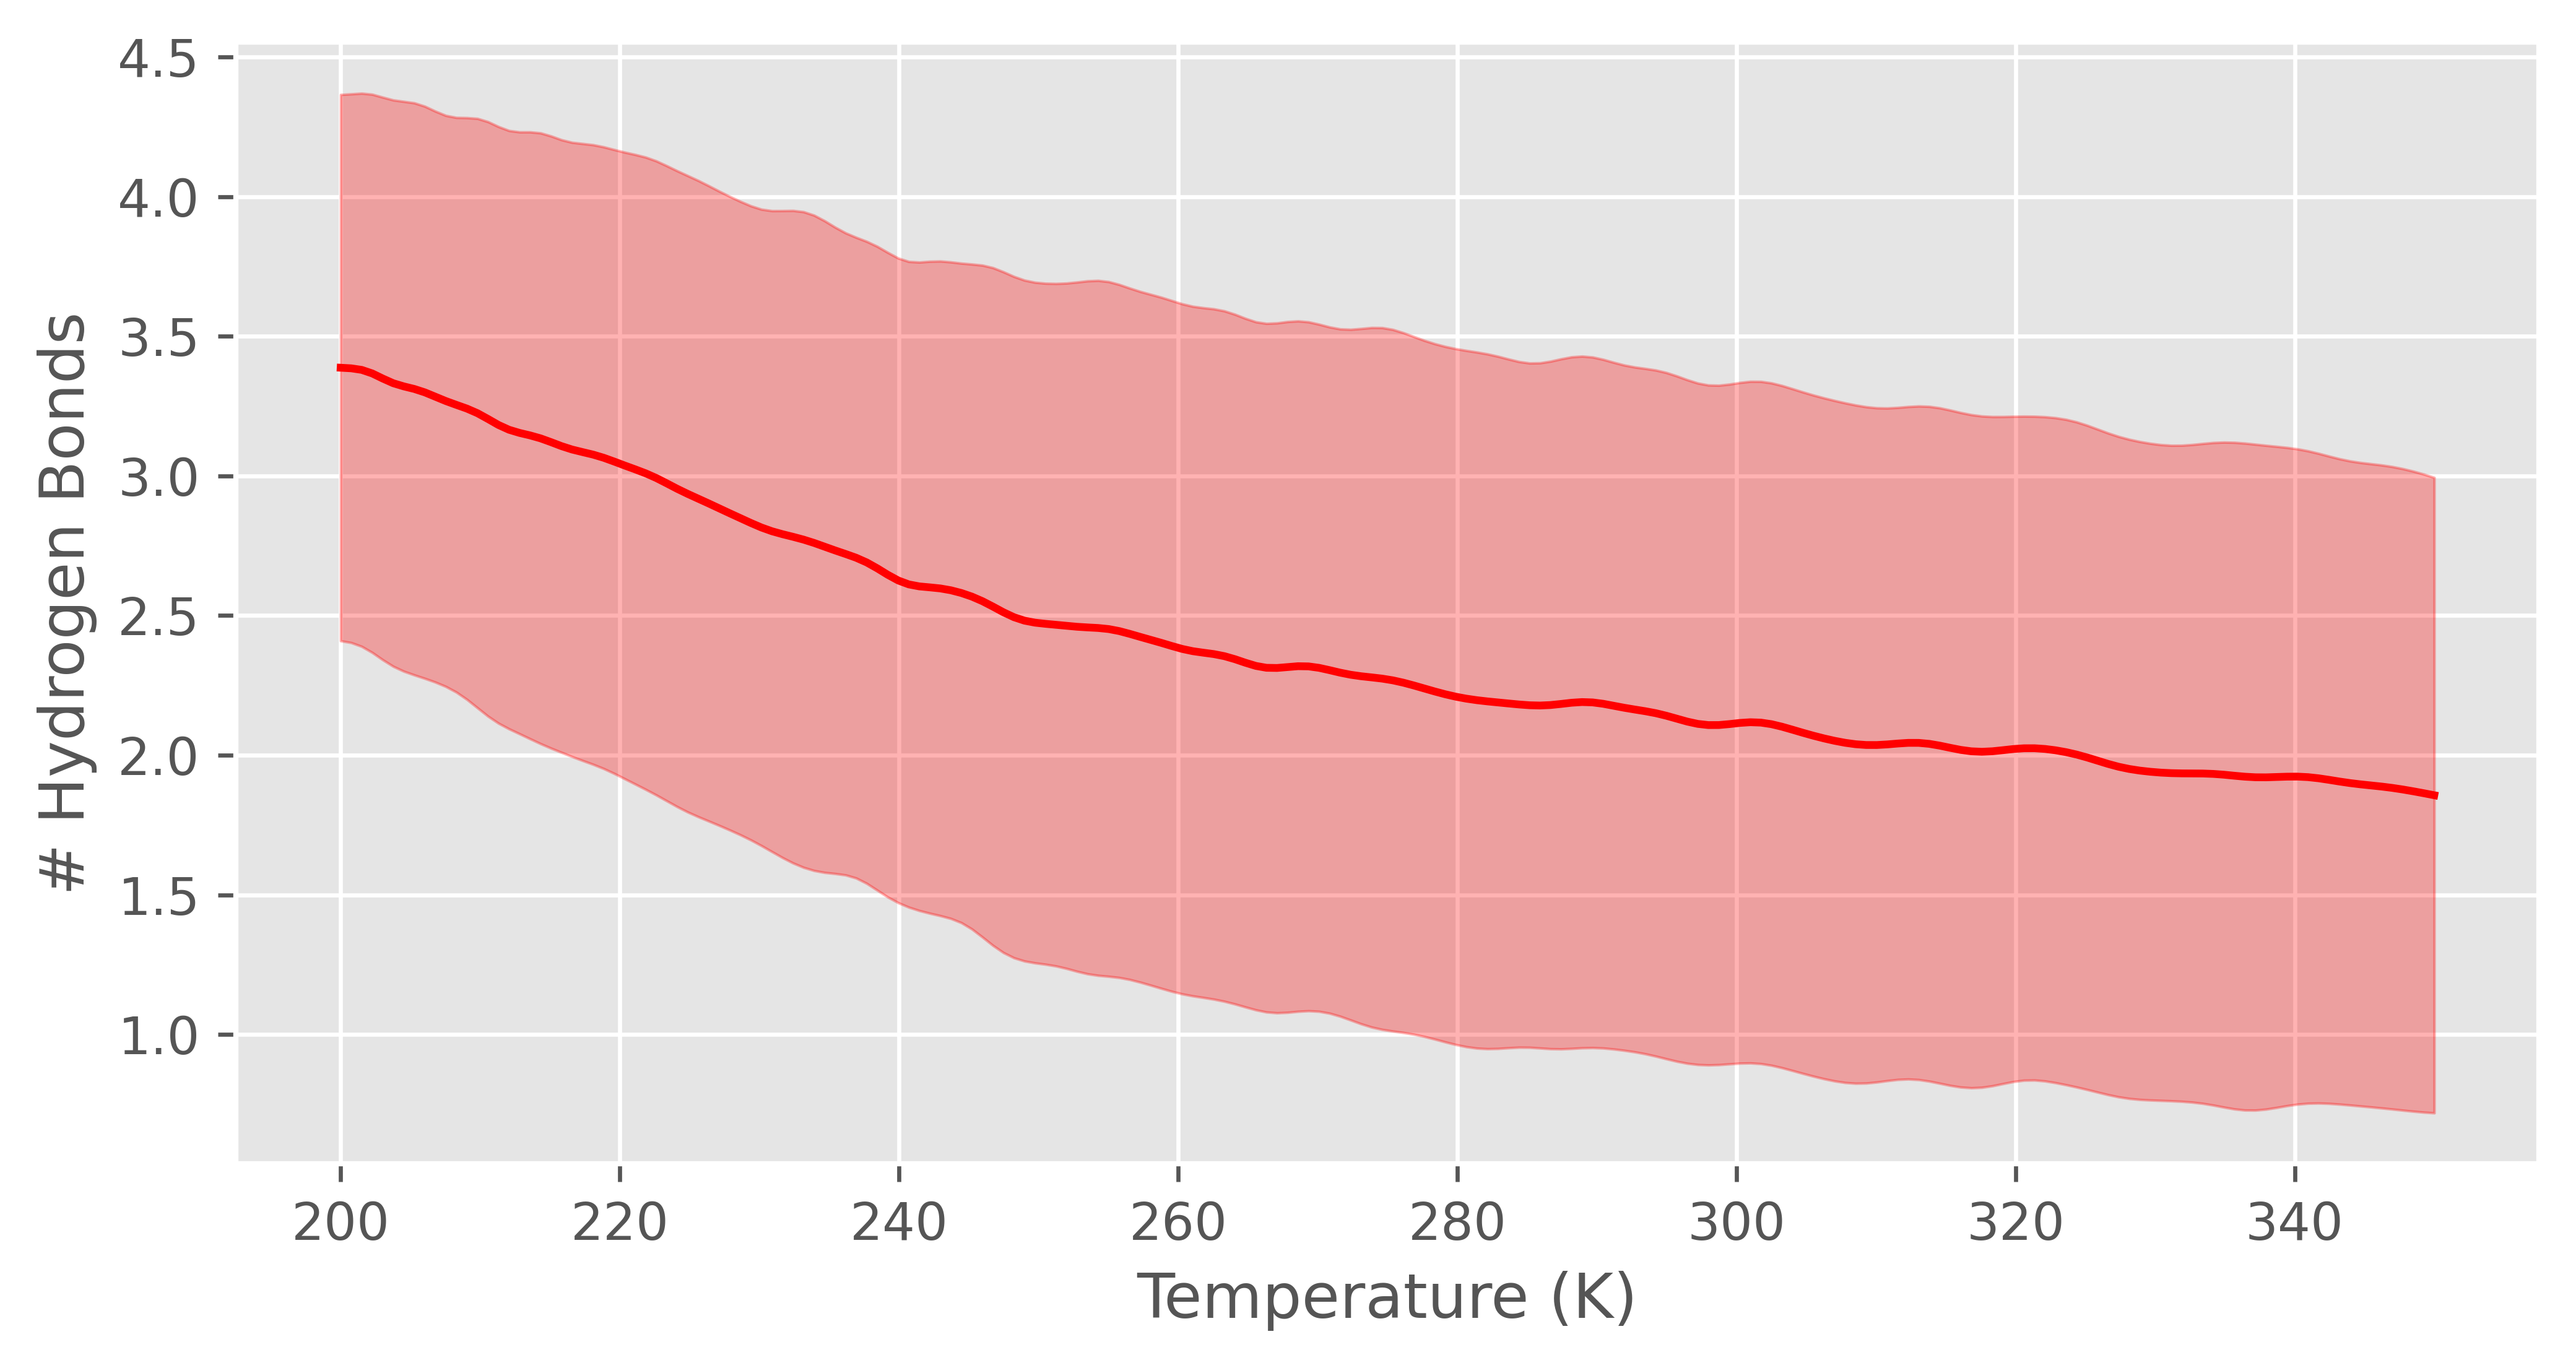

In [27]:
n_replicas = 40
plt.figure(figsize=[8,4], dpi=600)
# plt.scatter(t_list[:n_replicas], h_bonds_mu[:n_replicas])
plt.plot(t_list[n_replicas:], h_bonds_mu[n_replicas:], c="red")
plt.fill_between(t_list[n_replicas:], h_bonds_mu[n_replicas:]-h_bonds_sigma[n_replicas:],  h_bonds_mu[n_replicas:]+h_bonds_sigma[n_replicas:], color="red", alpha = 0.3)


plt.ylabel("# Hydrogen Bonds")
plt.xlabel("Temperature (K)")